In [ ]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D
import matplotlib.pyplot as plt
from tensorflow.keras import Model
import numpy as np
import os



In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)
BATCH_SIZE =32
IMG_SIZE = (160,160)
train_dir = 'drive/MyDrive/imageset/train'
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,shuffle=True,batch_size=BATCH_SIZE,image_size=IMG_SIZE)
val_dir = 'drive/MyDrive/imageset/val'
validation_dataset = tf.keras.utils.image_dataset_from_directory(val_dir,shuffle=True,batch_size=BATCH_SIZE,image_size=IMG_SIZE)

Mounted at /content/drive
Found 9479 files belonging to 10 classes.
Found 3925 files belonging to 10 classes.


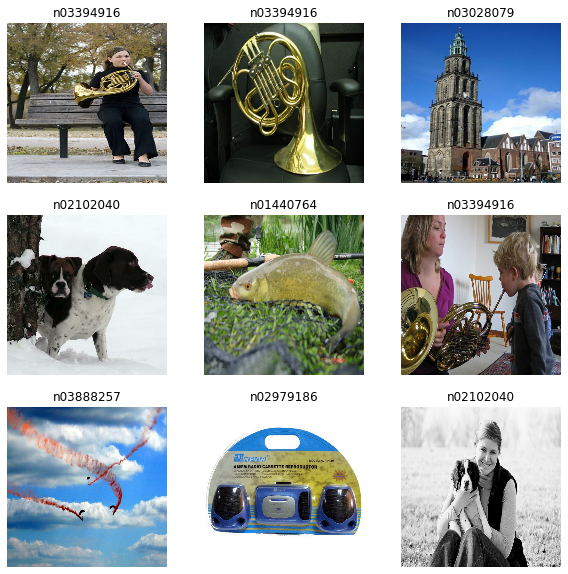

In [ ]:
class_names = train_dataset.class_names
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
 for i in range(9):
   ax = plt.subplot(3, 3, i + 1)
   plt.imshow(images[i].numpy().astype("uint8"))
   plt.title(class_names[labels[i]])
   plt.axis("off")

In [ ]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 99
Number of test batches: 24


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

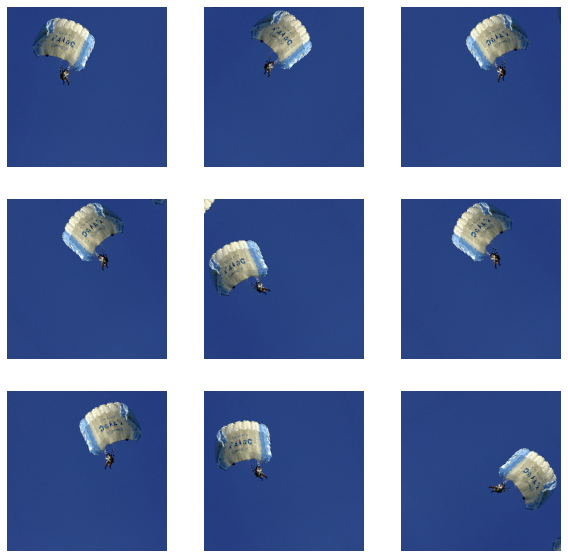

In [ ]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [ ]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)
base_model.trainable = False

(32, 5, 5, 1280)


In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [ ]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [ ]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
base_learning_rate = 0.001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

In [ ]:
len(model.trainable_variables)

2

In [ ]:
initial_epochs = 5
loss0, accuracy0 = model.evaluate(validation_dataset)

99/99 [==============================] - 50s 453ms/step - loss: -1.1698 - accuracy: 0.1140


In [ ]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: -1.17
initial accuracy: 0.11


In [ ]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/5
297/297 [==============================] - 836s 3s/step - loss: -245.6450 - accuracy: 0.1011 - val_loss: -423.3285 - val_accuracy: 0.0995
Epoch 2/5
297/297 [==============================] - 217s 727ms/step - loss: -732.8170 - accuracy: 0.1007 - val_loss: -847.0504 - val_accuracy: 0.0976
Epoch 3/5
297/297 [==============================] - 211s 708ms/step - loss: -1226.3345 - accuracy: 0.1007 - val_loss: -1269.6935 - val_accuracy: 0.1001
Epoch 4/5
297/297 [==============================] - 212s 710ms/step - loss: -1717.1094 - accuracy: 0.1007 - val_loss: -1683.3644 - val_accuracy: 0.1004
Epoch 5/5
297/297 [==============================] - 210s 704ms/step - loss: -2200.7637 - accuracy: 0.1007 - val_loss: -2117.6189 - val_accuracy: 0.0988


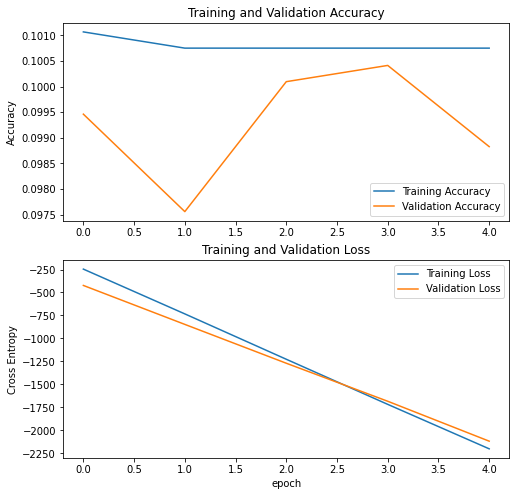

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
base_model.trainable = True

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 154

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

In [ ]:
len(model.trainable_variables)

2

In [ ]:
fine_tune_epochs = 5
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 5/10
297/297 [==============================] - 546s 732ms/step - loss: -2486.2075 - accuracy: 0.1007 - val_loss: -2161.7134 - val_accuracy: 0.1001
Epoch 6/10
297/297 [==============================] - 217s 729ms/step - loss: -2523.4368 - accuracy: 0.1007 - val_loss: -2204.0898 - val_accuracy: 0.0998
Epoch 7/10
297/297 [==============================] - 199s 668ms/step - loss: -2577.7351 - accuracy: 0.1007 - val_loss: -2243.2815 - val_accuracy: 0.0982
Epoch 8/10
297/297 [==============================] - 216s 723ms/step - loss: -2619.3953 - accuracy: 0.1007 - val_loss: -2294.9885 - val_accuracy: 0.0982
Epoch 9/10
297/297 [==============================] - 229s 768ms/step - loss: -2668.9795 - accuracy: 0.1007 - val_loss: -2330.8318 - val_accuracy: 0.1001
Epoch 10/10
297/297 [==============================] - 227s 761ms/step - loss: -2715.3635 - accuracy: 0.1007 - val_loss: -2365.0754 - val_accuracy: 0.0985


In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

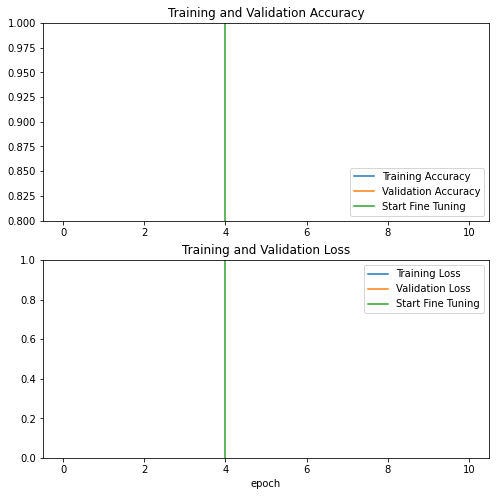

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

24/24 [==============================] - 15s 566ms/step - loss: -2336.0405 - accuracy: 0.1133
Test accuracy : 0.11328125
